# Set-up

Imports

In [1]:
import json
import numpy as np
import jax.numpy as jnp
import surrojax_gp
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
import sys
import time
sys.path.insert(0, '..')
import plotting_helpers

Plotting settings

In [2]:
# dpi of images displayed in notebook:
mpl.rcParams['figure.dpi'] = 100
# dpi of images saved to seperate folder:
mpl_save_dpi = 300

Define directory of beam data and directory of where figures are saved:

In [3]:
data_dir = '../fenics_models/data'
fig_save_dir = './figs'
if not os.path.isdir(fig_save_dir):
    os.mkdir(fig_save_dir)

Load test and train data:

In [4]:
def load_beam_data(file_dir):
    with open(file_dir, 'r') as f:
        data = json.load(f)
    x = jnp.stack([jnp.array(data[key]) for key in ('C_1', 'beam_angle')], axis=-1)
    y = jnp.array(jnp.array(data['end_disp'])).reshape(-1,1)
    return {'x': x, 'y': y}

beam_training_data = load_beam_data(os.path.join(data_dir, 'neohookean_beam_training_data.json'))
beam_test_data = load_beam_data(os.path.join(data_dir, 'neohookean_beam_test_data.json'))

Since the `C_1` and `beam_angle` parameters take on different ranges of values, it's good pratice to normalise our data using the range of values observed throughout the test and training data:

In [5]:
def scale_data(train_data, test_data):
    for key in train_data.keys():
        train_val, test_val = train_data[key], test_data[key]
        combined = jnp.concatenate([train_val, test_val], axis=0)
        min_val, max_val = jnp.min(combined,axis=0), jnp.max(combined,axis=0)
        train_data[key] = (train_val-min_val)/(max_val-min_val)
        test_data[key] = (test_val-min_val)/(max_val-min_val)
    return train_data, test_data

beam_training_data, beam_test_data = scale_data(beam_training_data, beam_test_data)

Define and train Gaussian process model - let's also time how long it takes to train the GP:

In [6]:
# Squared Exponential kernel:
def kernel(x_1, x_2, params):
    lengths = jnp.array([params[f"length_{i}"] for i in range(2)])
    inv_lengths = jnp.diag(lengths**(-1))
    ln_k_d = -0.5*(x_1 - x_2).T @ inv_lengths @ (x_1 - x_2) 
    return params["const"]*jnp.exp(ln_k_d)
constraints = {"length_0": {">": 0.01, "<": 1}, 
               "length_1": {">": 0.01, "<": 1}, 
               "const": {">": 0.01, "<": 1}}
print('Training GP...')
np.random.seed(42)
time_0 = time.time()
beam_gp = surrojax_gp.create_gp(kernel, beam_training_data['x'], beam_training_data['y'], constraints)
t_train = time.time() - time_0
print(f'Took {t_train:.2f} seconds to train GP surrogate.')

Training GP...
7371.919
53.309532
-236.31952
-306.9359
-156.25922
-308.33328
-311.2404
-308.5251
-266.23132
-296.50082
-309.62366
-278.92624
-303.8936
-309.12665
-307.73364
-309.62366
-309.62366
-309.62366
-309.62366
-309.62366
-309.62366
-309.62366
-309.62366
-309.62366
-309.62366
-309.62366
-309.62366
-309.62366
      fun: array(-309.62365723)
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([   7.99943161,  -76.87408447, -431.94384766])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 28
      nit: 6
     njev: 28
   status: 0
  success: True
        x: array([0.98647259, 0.15382936, 0.06653182])
-216.90231
53.309532
-264.4601
-292.75116
-308.1975
-304.45813
-302.7616
-303.26624
-303.11917
-304.4005
-299.69705
-304.45813
-304.45813
-304.45813
-304.45813
-304.45813
-304.45813
-304.45813
-304.45813
-304.45813
-304.45813
      fun: array(-304.45812988)
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([  10.27577591,

Let's now save this Gaussian process model:

In [7]:
surrojax_gp.save_gp(beam_gp, "nonlinear_beam_gp")

Let's now plot our trained GP evaluated at the training points:

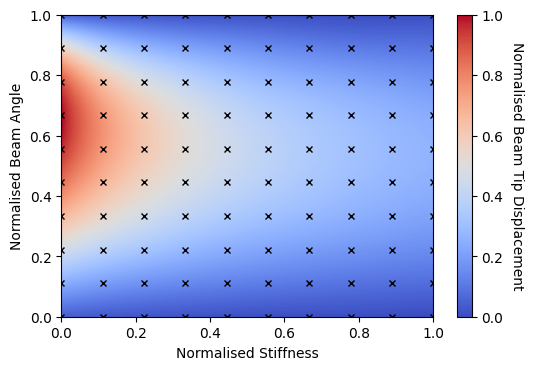

In [8]:
C_1_lims = (0, 1)
angle_lims = (0, 1)
num_C_1_pts = num_angle_pts = 30
C_1_grid, angle_grid, pred_pts = plotting_helpers.create_gp_prediction_grid(C_1_lims, angle_lims, num_C_1_pts, num_angle_pts)
gp_pred = beam_gp.predict(pred_pts)['mean']
fig = plotting_helpers.plot_beam_data(C_1_grid, angle_grid, gp_pred, grid_shape=(num_angle_pts, num_C_1_pts), 
                                      train_pts=beam_training_data, z_label='Normalised Beam Tip Displacement')
plt.savefig(os.path.join(fig_save_dir, 'gp_pred_training.png'), dpi=mpl_save_dpi)
fig.show()

For the sake of comparison, let's compare this plot against the raw training data:

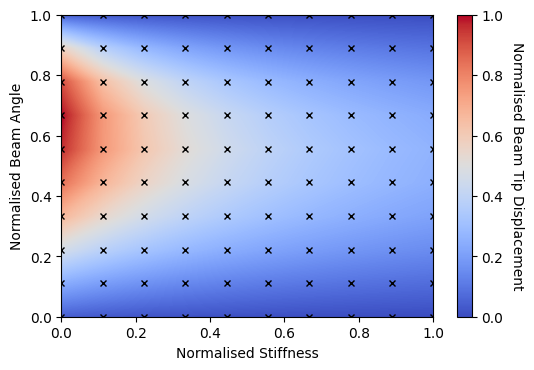

In [9]:
num_train_pts = 10
fig = plotting_helpers.plot_beam_data(beam_training_data['x'][:,0], beam_training_data['x'][:,1], 
                                      beam_training_data['y'], grid_shape=(num_train_pts, num_train_pts), 
                                      train_pts=beam_training_data, z_label='Normalised Beam Tip Displacement')
plt.savefig(os.path.join(fig_save_dir, 'raw_training.png'), dpi=mpl_save_dpi)
fig.show()

To quantitatively evaluate the accuracy of our GP, let's use our test data set - we'll also time how long it takes to make these predictions:

Predictions took 0.54427 seconds to compute


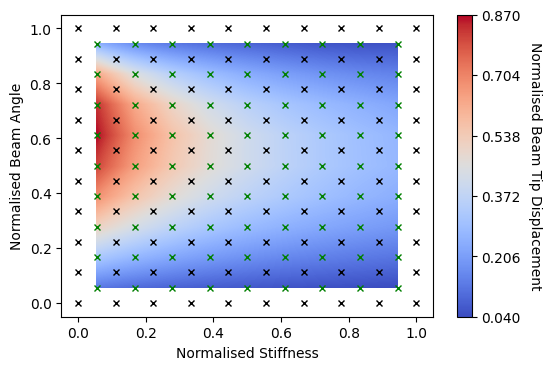

In [10]:
time_0 = time.time()
gp_pred = beam_gp.predict(beam_test_data['x'])['mean']
time_pred = time.time() - time_0
print(f'Predictions took {time_pred:.5f} seconds to compute')
num_test_pts = num_train_pts - 1
fig = plotting_helpers.plot_beam_data(beam_test_data['x'][:,0], beam_test_data['x'][:,1], gp_pred, 
                                      grid_shape=(num_test_pts, num_test_pts), 
                                      train_pts=beam_training_data, test_pts=beam_test_data,
                                      z_label='Normalised Beam Tip Displacement')
plt.savefig(os.path.join(fig_save_dir, 'gp_pred_test.png'), dpi=mpl_save_dpi)
fig.show()

Comparing this against the raw test data set:

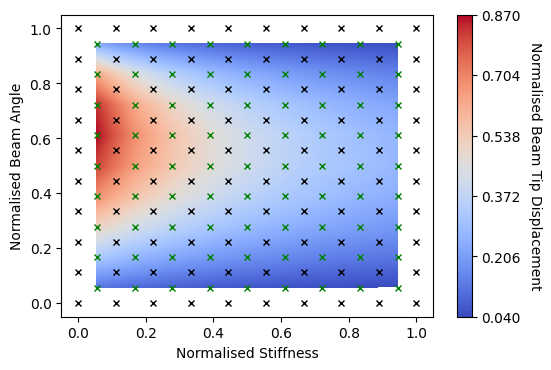

In [11]:
fig = plotting_helpers.plot_beam_data(beam_test_data['x'][:,0], beam_test_data['x'][:,1], beam_test_data['y'], 
                                      grid_shape=(num_test_pts, num_test_pts), 
                                      train_pts=beam_training_data, test_pts=beam_test_data,
                                      z_label='Normalised Beam Tip Displacement')
plt.savefig(os.path.join(fig_save_dir, 'raw_test.png'), dpi=mpl_save_dpi)
fig.show()

Let's now compute various errors associated with our GP model:

In [12]:
errors = jnp.abs(gp_pred - beam_test_data['y'].squeeze())
max_error = jnp.max(errors)
avg_error = jnp.mean(errors)
median_error = jnp.median(errors)
print(f'Maximum error = {max_error}, \nAverage error = {avg_error}, \nMedian error = {median_error}')

Maximum error = 0.016997694969177246, 
Average error = 0.0021849661134183407, 
Median error = 0.0012704133987426758


Let's also visualise our the errors in our GP:

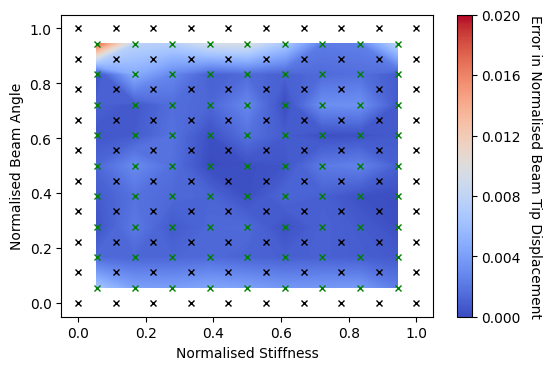

In [13]:
fig = plotting_helpers.plot_beam_data(beam_test_data['x'][:,0], beam_test_data['x'][:,1], errors, 
                                z_label='Error in Normalised Beam Tip Displacement', 
                                grid_shape=(9,9), train_pts=beam_training_data, test_pts=beam_test_data)
plt.savefig(os.path.join(fig_save_dir, 'gp_error.png'), dpi=mpl_save_dpi)
fig.show()

Let's now see what the gradients produced by our GP look like - first, the gradient wrt $C_1$:

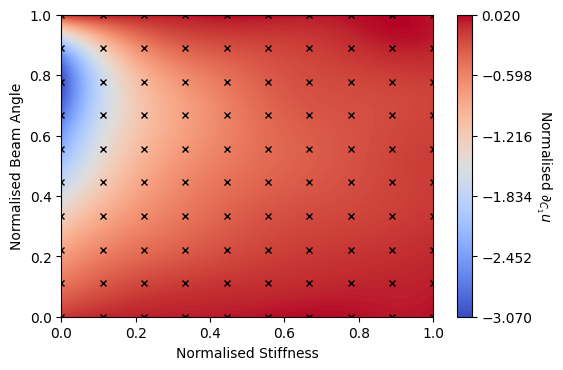

In [14]:
C_1_lims = (0, 1)
angle_lims = (0, 1)
num_C_1_pts = num_angle_pts = 30
C_1_grid, angle_grid, pred_pts = plotting_helpers.create_gp_prediction_grid(C_1_lims, angle_lims, num_C_1_pts, num_angle_pts)
grad_pred = beam_gp.predict(pred_pts, grad=({'idx':[0], 'order':1},))
fig = plotting_helpers.plot_beam_data(C_1_grid, angle_grid, grad_pred['mean'], grid_shape=(num_angle_pts, num_C_1_pts), 
                                      train_pts=beam_training_data, z_label='Normalised $\partial_{C_1} u$ ')
plt.savefig(os.path.join(fig_save_dir, 'gp_dC1_pred.png'), dpi=mpl_save_dpi)
fig.show()

Next, the gradient wrt the beam angle:

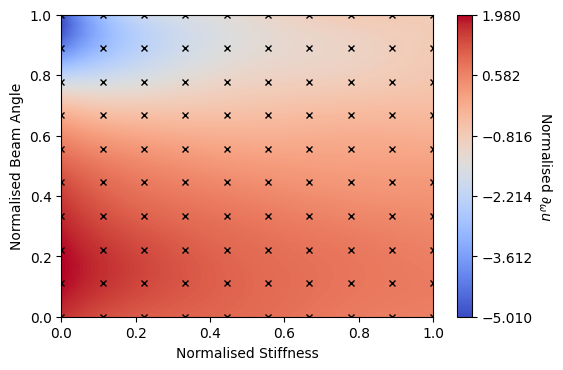

In [15]:
C_1_lims = (0, 1)
angle_lims = (0, 1)
num_C_1_pts = num_angle_pts = 30
C_1_grid, angle_grid, pred_pts = plotting_helpers.create_gp_prediction_grid(C_1_lims, angle_lims, num_C_1_pts, num_angle_pts)
grad_pred = beam_gp.predict(pred_pts, grad=({'idx':[1], 'order':1},))
fig = plotting_helpers.plot_beam_data(C_1_grid, angle_grid, grad_pred['mean'], grid_shape=(num_angle_pts, num_C_1_pts), 
                                      train_pts=beam_training_data, z_label='Normalised $\partial_{\omega} u$ ')
plt.savefig(os.path.join(fig_save_dir, 'gp_dangle_pred.png'), dpi=mpl_save_dpi)
fig.show()

Next, the second derivative wrt the beam angle:

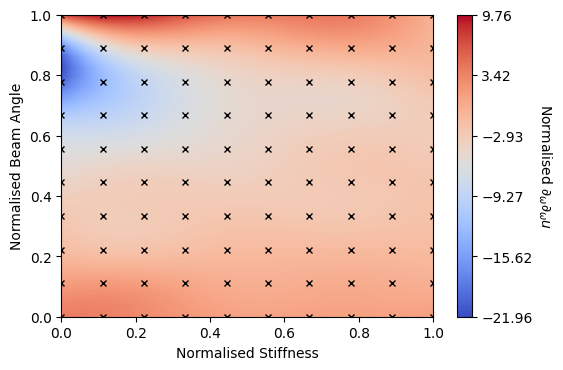

In [16]:
C_1_lims = (0, 1)
angle_lims = (0, 1)
num_C_1_pts = num_angle_pts = 30
C_1_grid, angle_grid, pred_pts = plotting_helpers.create_gp_prediction_grid(C_1_lims, angle_lims, num_C_1_pts, num_angle_pts)
grad_pred = beam_gp.predict(pred_pts, grad=({'idx':[1], 'order':2},))
fig = plotting_helpers.plot_beam_data(C_1_grid, angle_grid, grad_pred['mean'], grid_shape=(num_angle_pts, num_C_1_pts), 
                                      train_pts=beam_training_data, 
                                      z_label='Normalised $\partial_{\omega} \partial_{\omega} u$ ')
plt.savefig(os.path.join(fig_save_dir, 'gp_dangle2_pred.png'), dpi=mpl_save_dpi)
fig.show()

Finally, the mixed derivative wrt $C_1$ and the beam angle:

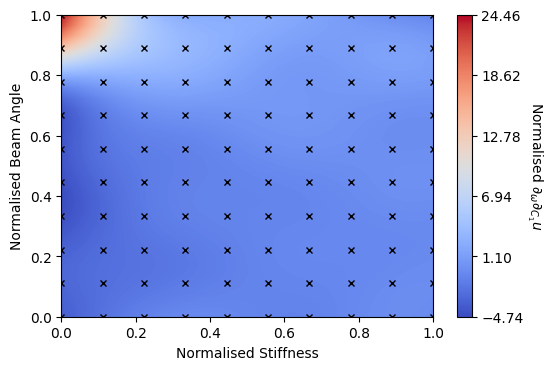

In [17]:
C_1_lims = (0, 1)
angle_lims = (0, 1)
num_C_1_pts = num_angle_pts = 30
C_1_grid, angle_grid, pred_pts = plotting_helpers.create_gp_prediction_grid(C_1_lims, angle_lims, num_C_1_pts, num_angle_pts)
grad_pred = beam_gp.predict(pred_pts, grad=({'idx':[0], 'order':1}, {'idx':[1], 'order':1}) )
fig = plotting_helpers.plot_beam_data(C_1_grid, angle_grid, grad_pred['mean'], grid_shape=(num_angle_pts, num_C_1_pts), 
                                      train_pts=beam_training_data, z_label='Normalised $\partial_{\omega} \partial_{C_1} u$ ')
plt.savefig(os.path.join(fig_save_dir, 'gp_dC1_dangle_pred.png'), dpi=mpl_save_dpi)
fig.show()